# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [34]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

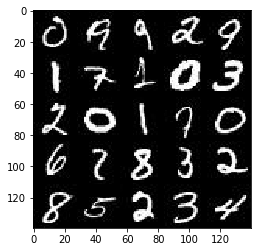

In [35]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

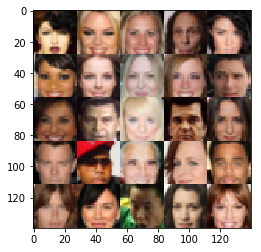

In [36]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [38]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, output_dim, training=True):

    reuse_status = not training

    alpha = 0.2

    with tf.variable_scope('generator', reuse=reuse_status):

        x0 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(x0, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=training)
        x0 = tf.maximum(alpha * x0, x0)
        # 2x2x1024 now

        x1 = tf.layers.conv2d_transpose(x0, 512, 4, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
    
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256

        x21 = tf.layers.conv2d_transpose(x2, 256, 1, strides=1, padding='same')
        x21 = tf.layers.batch_normalization(x2, training=training)
        x21 = tf.maximum(alpha * x21, x21)
        # 7x7x256


        x3 = tf.layers.conv2d_transpose(x21, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now

        x4 = tf.layers.conv2d_transpose(x3, 128, 1, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x3, training=training)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x256 now


        # Output layer
        logits = tf.layers.conv2d_transpose(x4, output_dim, 5, strides=2, padding='same')
        # 28x28x3 now
    
        out = tf.tanh(logits)
    
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, training=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    steps = 0
    show_every = 100
    print_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 3.1273... Generator Loss: 0.0577


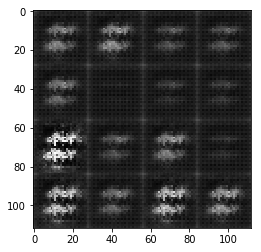

Epoch 0/2... Discriminator Loss: 0.8918... Generator Loss: 0.7908
Epoch 0/2... Discriminator Loss: 1.1871... Generator Loss: 6.2926


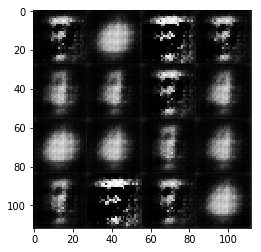

Epoch 0/2... Discriminator Loss: 0.4906... Generator Loss: 1.6936
Epoch 0/2... Discriminator Loss: 0.4116... Generator Loss: 1.6357


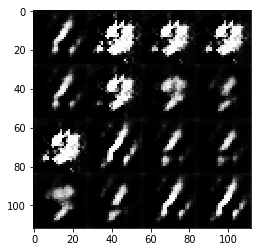

Epoch 0/2... Discriminator Loss: 0.7273... Generator Loss: 0.9001
Epoch 0/2... Discriminator Loss: 0.7282... Generator Loss: 5.1556


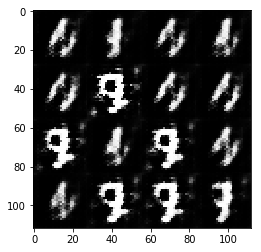

Epoch 0/2... Discriminator Loss: 0.4189... Generator Loss: 3.1426
Epoch 0/2... Discriminator Loss: 0.9095... Generator Loss: 1.0830


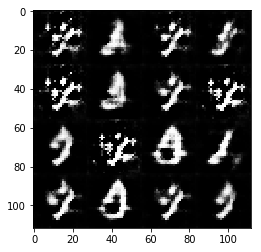

Epoch 0/2... Discriminator Loss: 0.3982... Generator Loss: 2.1468
Epoch 0/2... Discriminator Loss: 0.6729... Generator Loss: 1.9628


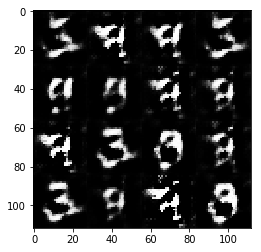

Epoch 0/2... Discriminator Loss: 1.1093... Generator Loss: 0.7805
Epoch 0/2... Discriminator Loss: 0.5733... Generator Loss: 1.5348


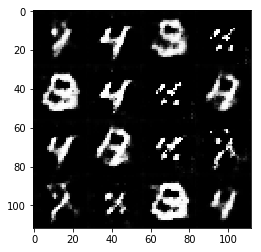

Epoch 0/2... Discriminator Loss: 0.4949... Generator Loss: 1.9153
Epoch 0/2... Discriminator Loss: 0.7437... Generator Loss: 1.0081


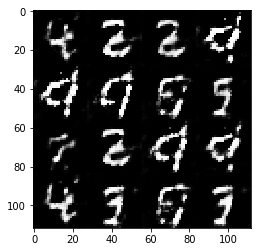

Epoch 0/2... Discriminator Loss: 0.7564... Generator Loss: 3.3971
Epoch 0/2... Discriminator Loss: 0.7403... Generator Loss: 1.4251


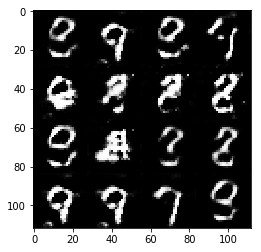

Epoch 0/2... Discriminator Loss: 0.7886... Generator Loss: 2.4387
Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.7398


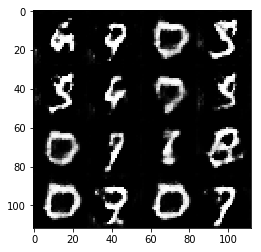

Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 2.4033
Epoch 1/2... Discriminator Loss: 1.1052... Generator Loss: 2.4489


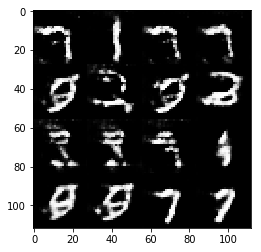

Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.4572
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 0.9365


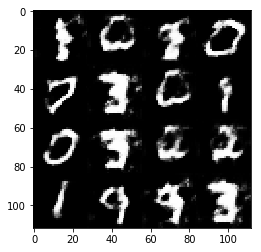

Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.6780
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.4149


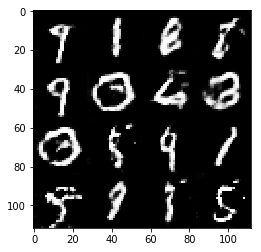

Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 2.2874
Epoch 1/2... Discriminator Loss: 0.6650... Generator Loss: 1.5645


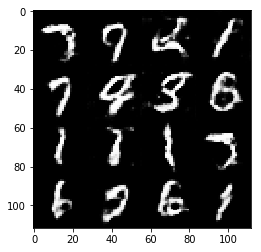

Epoch 1/2... Discriminator Loss: 0.9004... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.8018


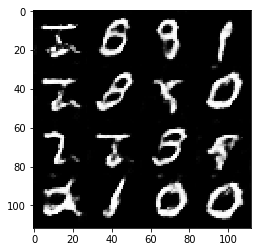

Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.1009
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.6489


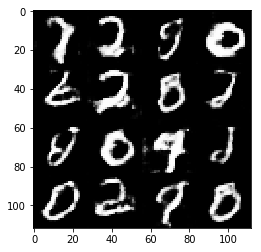

Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.1142
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.1590


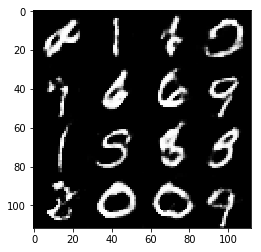

Epoch 1/2... Discriminator Loss: 0.8171... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 1.0941... Generator Loss: 2.4695


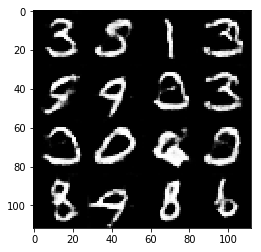

Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 1.1866


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.7291... Generator Loss: 1.1915


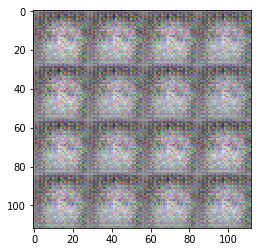

Epoch 0/1... Discriminator Loss: 0.6276... Generator Loss: 1.1805
Epoch 0/1... Discriminator Loss: 0.3639... Generator Loss: 3.3122


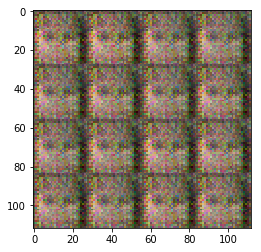

Epoch 0/1... Discriminator Loss: 0.4501... Generator Loss: 2.0033
Epoch 0/1... Discriminator Loss: 0.3517... Generator Loss: 3.4529


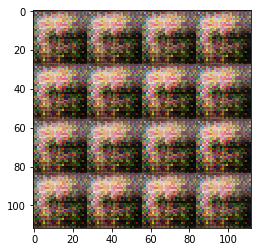

Epoch 0/1... Discriminator Loss: 0.1869... Generator Loss: 2.6264
Epoch 0/1... Discriminator Loss: 0.1586... Generator Loss: 2.8333


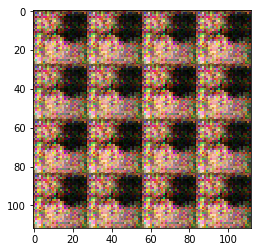

Epoch 0/1... Discriminator Loss: 0.1891... Generator Loss: 2.4385
Epoch 0/1... Discriminator Loss: 0.1149... Generator Loss: 3.1461


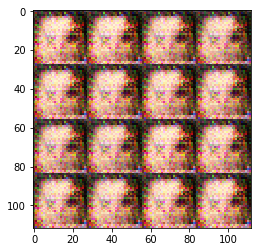

Epoch 0/1... Discriminator Loss: 0.3614... Generator Loss: 4.1785
Epoch 0/1... Discriminator Loss: 0.0990... Generator Loss: 2.8233


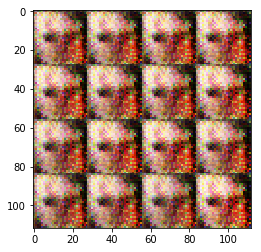

Epoch 0/1... Discriminator Loss: 0.2007... Generator Loss: 2.0225
Epoch 0/1... Discriminator Loss: 0.5181... Generator Loss: 1.1681


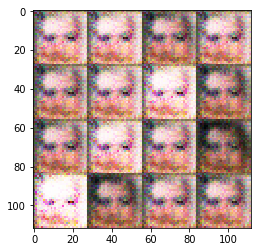

Epoch 0/1... Discriminator Loss: 0.9170... Generator Loss: 0.8890
Epoch 0/1... Discriminator Loss: 0.9966... Generator Loss: 1.6413


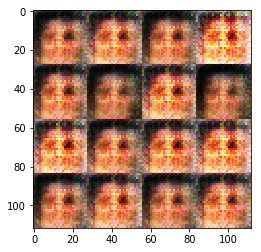

Epoch 0/1... Discriminator Loss: 0.7816... Generator Loss: 0.9995
Epoch 0/1... Discriminator Loss: 1.2518... Generator Loss: 1.9046


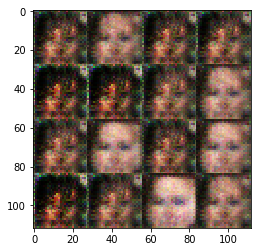

Epoch 0/1... Discriminator Loss: 0.7215... Generator Loss: 1.6303
Epoch 0/1... Discriminator Loss: 0.6993... Generator Loss: 1.5536


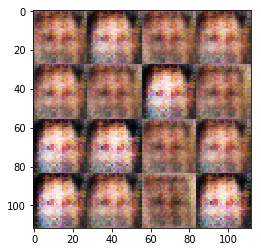

Epoch 0/1... Discriminator Loss: 1.3769... Generator Loss: 1.1305
Epoch 0/1... Discriminator Loss: 0.8673... Generator Loss: 1.2868


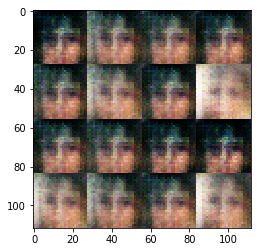

Epoch 0/1... Discriminator Loss: 0.4858... Generator Loss: 1.9312
Epoch 0/1... Discriminator Loss: 0.9566... Generator Loss: 2.2531


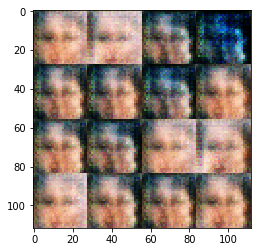

Epoch 0/1... Discriminator Loss: 0.8062... Generator Loss: 1.7998
Epoch 0/1... Discriminator Loss: 0.3288... Generator Loss: 1.9762


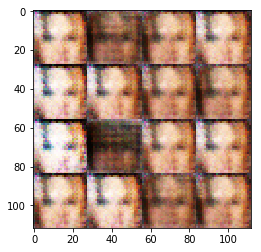

Epoch 0/1... Discriminator Loss: 0.9647... Generator Loss: 2.3166
Epoch 0/1... Discriminator Loss: 0.7700... Generator Loss: 0.9611


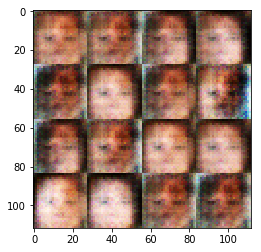

Epoch 0/1... Discriminator Loss: 0.5018... Generator Loss: 1.5004
Epoch 0/1... Discriminator Loss: 1.2260... Generator Loss: 1.2436


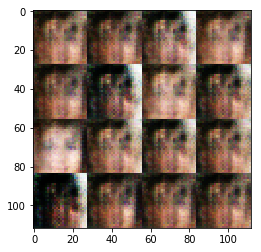

Epoch 0/1... Discriminator Loss: 1.2297... Generator Loss: 1.1582
Epoch 0/1... Discriminator Loss: 0.5665... Generator Loss: 1.7103


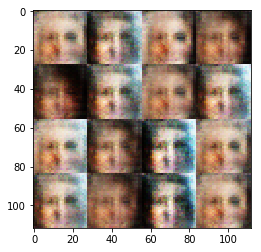

Epoch 0/1... Discriminator Loss: 0.8902... Generator Loss: 1.3107
Epoch 0/1... Discriminator Loss: 0.4207... Generator Loss: 2.0461


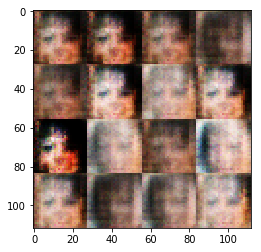

Epoch 0/1... Discriminator Loss: 0.7666... Generator Loss: 1.2274
Epoch 0/1... Discriminator Loss: 0.7769... Generator Loss: 1.9245


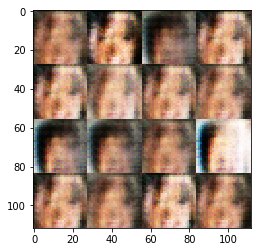

Epoch 0/1... Discriminator Loss: 0.5420... Generator Loss: 1.7360
Epoch 0/1... Discriminator Loss: 0.5356... Generator Loss: 1.6250


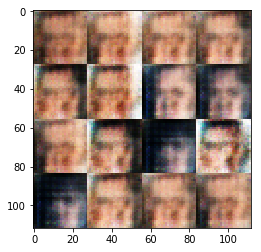

Epoch 0/1... Discriminator Loss: 0.8417... Generator Loss: 1.6180
Epoch 0/1... Discriminator Loss: 0.6589... Generator Loss: 1.5638


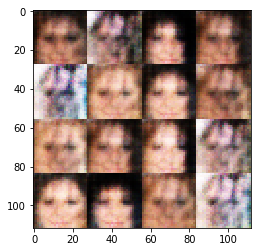

Epoch 0/1... Discriminator Loss: 0.8416... Generator Loss: 1.0121
Epoch 0/1... Discriminator Loss: 0.8571... Generator Loss: 1.1006


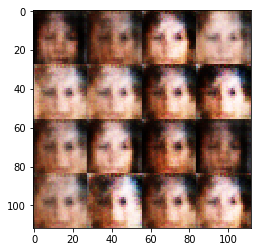

Epoch 0/1... Discriminator Loss: 0.7792... Generator Loss: 1.4687
Epoch 0/1... Discriminator Loss: 0.5754... Generator Loss: 1.2361


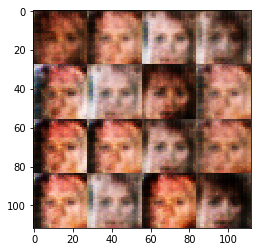

Epoch 0/1... Discriminator Loss: 0.6934... Generator Loss: 1.8681
Epoch 0/1... Discriminator Loss: 0.6706... Generator Loss: 1.4644


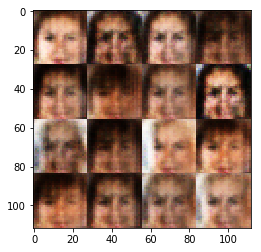

Epoch 0/1... Discriminator Loss: 0.9075... Generator Loss: 1.4880
Epoch 0/1... Discriminator Loss: 1.1066... Generator Loss: 1.3212


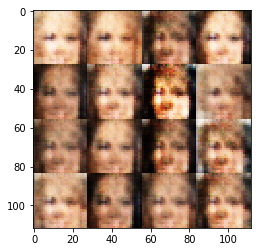

Epoch 0/1... Discriminator Loss: 0.5527... Generator Loss: 2.4085
Epoch 0/1... Discriminator Loss: 0.7281... Generator Loss: 1.3538


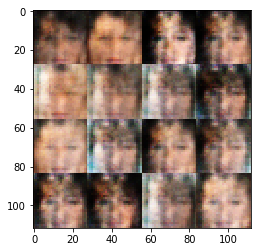

Epoch 0/1... Discriminator Loss: 0.6744... Generator Loss: 1.6103
Epoch 0/1... Discriminator Loss: 0.7414... Generator Loss: 1.3638


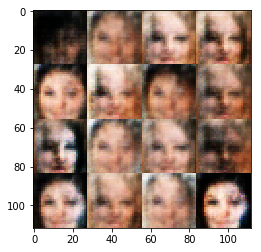

Epoch 0/1... Discriminator Loss: 0.8796... Generator Loss: 1.3065
Epoch 0/1... Discriminator Loss: 0.6058... Generator Loss: 1.4327


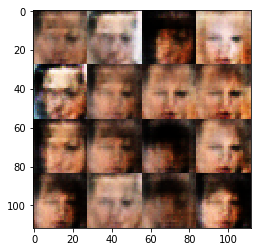

Epoch 0/1... Discriminator Loss: 0.6784... Generator Loss: 1.2926
Epoch 0/1... Discriminator Loss: 0.8062... Generator Loss: 1.1490


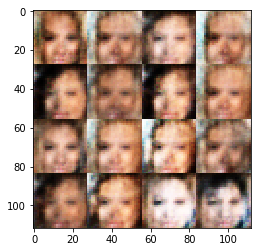

Epoch 0/1... Discriminator Loss: 0.5714... Generator Loss: 1.9823
Epoch 0/1... Discriminator Loss: 0.6664... Generator Loss: 1.7831


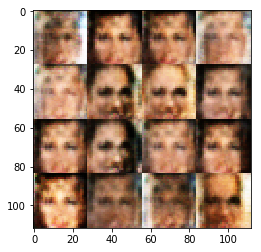

Epoch 0/1... Discriminator Loss: 0.7842... Generator Loss: 1.5264
Epoch 0/1... Discriminator Loss: 0.6530... Generator Loss: 1.3215


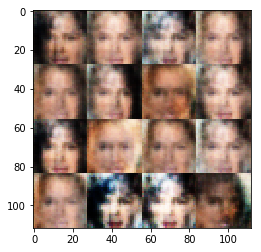

Epoch 0/1... Discriminator Loss: 0.8567... Generator Loss: 1.5339
Epoch 0/1... Discriminator Loss: 0.8668... Generator Loss: 1.3838


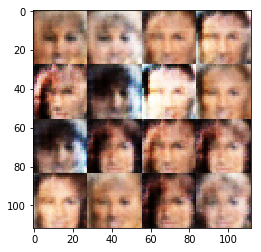

Epoch 0/1... Discriminator Loss: 1.0861... Generator Loss: 1.0250
Epoch 0/1... Discriminator Loss: 0.6841... Generator Loss: 1.2227


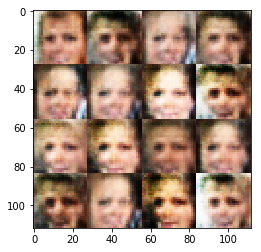

Epoch 0/1... Discriminator Loss: 0.9367... Generator Loss: 1.0537
Epoch 0/1... Discriminator Loss: 0.9590... Generator Loss: 0.9850


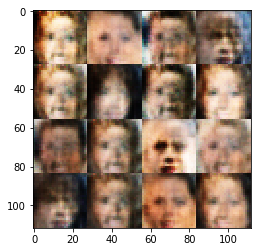

Epoch 0/1... Discriminator Loss: 1.1661... Generator Loss: 0.7196
Epoch 0/1... Discriminator Loss: 1.1549... Generator Loss: 1.2081


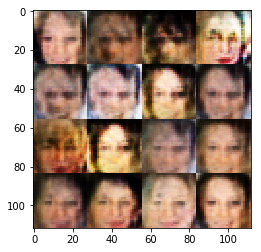

Epoch 0/1... Discriminator Loss: 0.9069... Generator Loss: 0.9851
Epoch 0/1... Discriminator Loss: 1.1186... Generator Loss: 0.6868


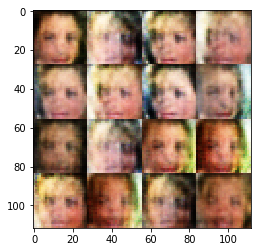

Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 0.9924
Epoch 0/1... Discriminator Loss: 0.8443... Generator Loss: 1.0819


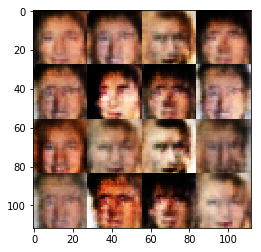

Epoch 0/1... Discriminator Loss: 1.0889... Generator Loss: 0.8935
Epoch 0/1... Discriminator Loss: 1.3528... Generator Loss: 0.6227


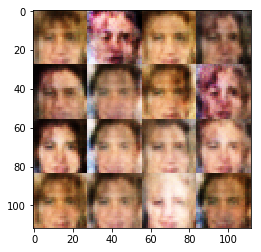

Epoch 0/1... Discriminator Loss: 0.9950... Generator Loss: 0.9917
Epoch 0/1... Discriminator Loss: 0.9937... Generator Loss: 1.4143


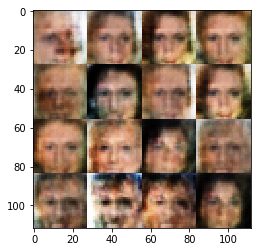

Epoch 0/1... Discriminator Loss: 1.5458... Generator Loss: 0.6276
Epoch 0/1... Discriminator Loss: 1.0148... Generator Loss: 1.0535


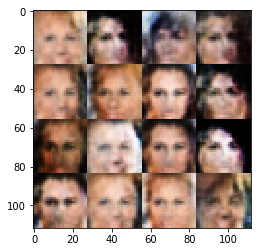

Epoch 0/1... Discriminator Loss: 0.9788... Generator Loss: 1.1376
Epoch 0/1... Discriminator Loss: 0.7067... Generator Loss: 1.3212


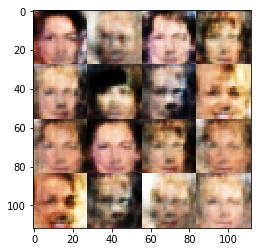

Epoch 0/1... Discriminator Loss: 0.7983... Generator Loss: 1.0474
Epoch 0/1... Discriminator Loss: 1.0118... Generator Loss: 1.3144


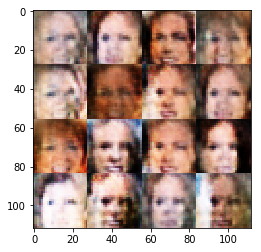

Epoch 0/1... Discriminator Loss: 1.0229... Generator Loss: 0.7261
Epoch 0/1... Discriminator Loss: 0.8521... Generator Loss: 1.8770


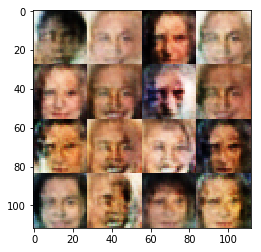

Epoch 0/1... Discriminator Loss: 1.2499... Generator Loss: 0.7336
Epoch 0/1... Discriminator Loss: 0.9148... Generator Loss: 1.1986


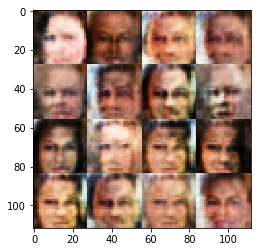

Epoch 0/1... Discriminator Loss: 1.1242... Generator Loss: 0.9574
Epoch 0/1... Discriminator Loss: 0.7765... Generator Loss: 1.3146


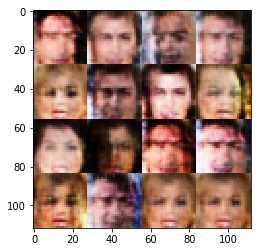

Epoch 0/1... Discriminator Loss: 1.3999... Generator Loss: 0.8297
Epoch 0/1... Discriminator Loss: 1.2965... Generator Loss: 0.5872


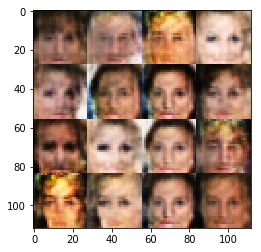

Epoch 0/1... Discriminator Loss: 1.0004... Generator Loss: 0.8870
Epoch 0/1... Discriminator Loss: 1.1494... Generator Loss: 0.9876


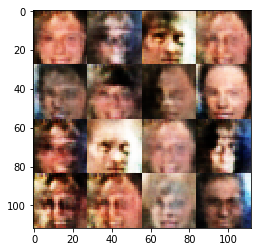

Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 0.7468
Epoch 0/1... Discriminator Loss: 0.8279... Generator Loss: 1.2639


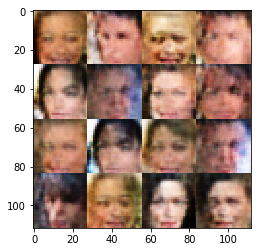

Epoch 0/1... Discriminator Loss: 1.1574... Generator Loss: 0.8219
Epoch 0/1... Discriminator Loss: 1.2223... Generator Loss: 1.1086


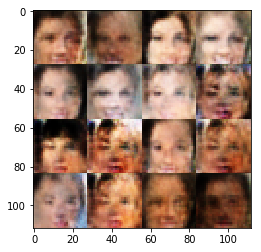

Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.7858
Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.8034


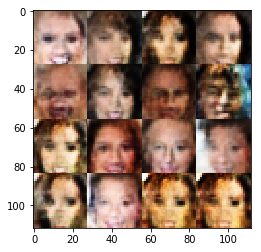

Epoch 0/1... Discriminator Loss: 1.0709... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 0.9575... Generator Loss: 1.1382


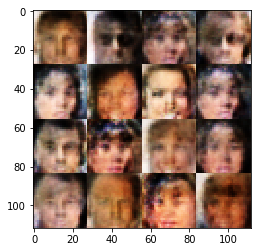

Epoch 0/1... Discriminator Loss: 1.0742... Generator Loss: 0.7708
Epoch 0/1... Discriminator Loss: 1.1535... Generator Loss: 0.8612


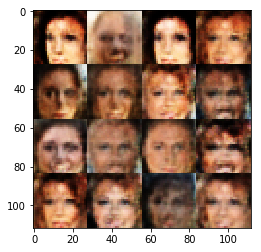

Epoch 0/1... Discriminator Loss: 0.9496... Generator Loss: 0.9083
Epoch 0/1... Discriminator Loss: 0.9172... Generator Loss: 1.1251


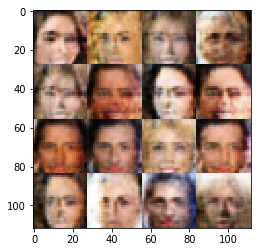

Epoch 0/1... Discriminator Loss: 0.8934... Generator Loss: 0.9440
Epoch 0/1... Discriminator Loss: 1.0567... Generator Loss: 0.8035


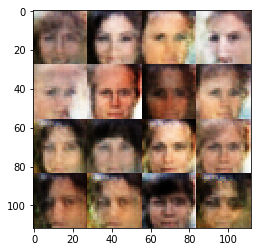

Epoch 0/1... Discriminator Loss: 1.0634... Generator Loss: 1.3097
Epoch 0/1... Discriminator Loss: 1.2743... Generator Loss: 0.5965


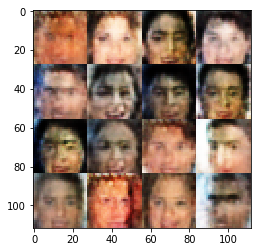

Epoch 0/1... Discriminator Loss: 1.1209... Generator Loss: 0.8944
Epoch 0/1... Discriminator Loss: 1.0818... Generator Loss: 0.9741


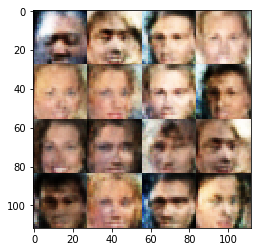

Epoch 0/1... Discriminator Loss: 0.8086... Generator Loss: 1.2325
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 1.1167


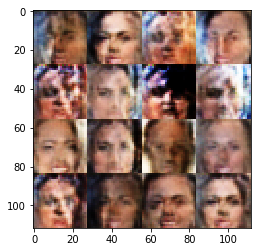

Epoch 0/1... Discriminator Loss: 1.1229... Generator Loss: 0.9074
Epoch 0/1... Discriminator Loss: 1.2955... Generator Loss: 0.6141


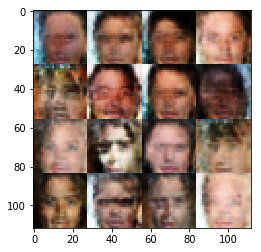

Epoch 0/1... Discriminator Loss: 1.1432... Generator Loss: 0.7600
Epoch 0/1... Discriminator Loss: 1.1141... Generator Loss: 1.2595


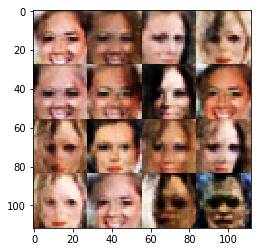

Epoch 0/1... Discriminator Loss: 0.8784... Generator Loss: 1.0087
Epoch 0/1... Discriminator Loss: 1.0722... Generator Loss: 0.8007


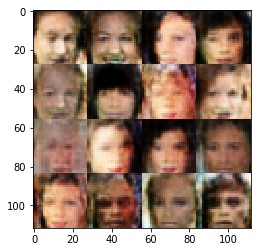

Epoch 0/1... Discriminator Loss: 1.0232... Generator Loss: 1.0204
Epoch 0/1... Discriminator Loss: 0.9670... Generator Loss: 0.8652


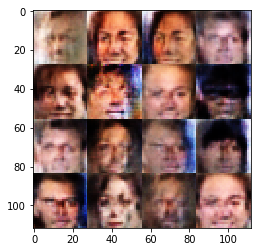

Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 0.8627
Epoch 0/1... Discriminator Loss: 0.9196... Generator Loss: 0.8235


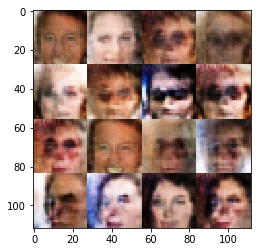

Epoch 0/1... Discriminator Loss: 1.0246... Generator Loss: 0.8107
Epoch 0/1... Discriminator Loss: 0.8340... Generator Loss: 1.0016


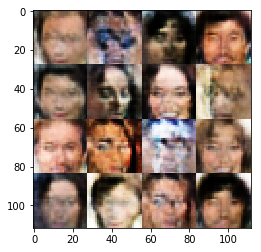

Epoch 0/1... Discriminator Loss: 0.9023... Generator Loss: 1.0207
Epoch 0/1... Discriminator Loss: 1.1792... Generator Loss: 0.6569


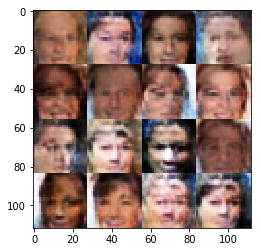

Epoch 0/1... Discriminator Loss: 1.0176... Generator Loss: 0.6896


In [48]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.